In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

In [ ]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 100

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

In [ ]:
!unzip /content/drive/MyDrive/changed_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: labels/train/khichdi_1742.txt  
  inflating: labels/train/khichdi_1743.txt  
  inflating: labels/train/khichdi_1744.txt  
  inflating: labels/train/khichdi_1745.txt  
  inflating: labels/train/khichdi_1746.txt  
  inflating: labels/train/khichdi_1751.txt  
  inflating: labels/train/khichdi_1752.txt  
  inflating: labels/train/khichdi_1753.txt  
  inflating: labels/train/khichdi_1754.txt  
  inflating: labels/train/khichdi_1758.txt  
  inflating: labels/train/khichdi_1759.txt  
  inflating: labels/train/khichdi_1760.txt  
  inflating: labels/train/khichdi_1761.txt  
  inflating: labels/train/khichdi_1764.txt  
  inflating: labels/train/khichdi_1768.txt  
  inflating: labels/train/khichdi_1770.txt  
  inflating: labels/train/khichdi_1772.txt  
  inflating: labels/train/khichdi_1773.txt  
  inflating: labels/train/khichdi_1775.txt  
  inflating: labels/train/khichdi_1777.txt  
  inflating: labels/train/khichdi_1778.txt  
  in

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have a directory with your original images
data_directory = '/content/dataset'
# Create an instance of the ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images within the range of 20 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by 10% of the total width
    height_shift_range=0.1,  # Randomly shift images vertically by 10% of the total height
    zoom_range=0.2,  # Randomly zoom images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    brightness_range=(0.8, 1.2)  # Randomly adjust brightness of images within the range 0.8 to 1.2
)

# Generate augmented images and save them to a new directory
augmented_directory = 'path/to/augmented_data'
data_generator.flow_from_directory(
    data_directory,
    batch_size=32,
    save_to_dir=augmented_directory,
    save_format='jpeg',
    save_prefix='augmented_'
)


Found 11537 images belonging to 3 classes.


In [ ]:
class_names = ['alooparatha', 'rasgulla', 'biryani', 'chickentikka', 'palakpaneer', 'poha', 'khichdi','omelette', 'plainrice', 'chapati']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

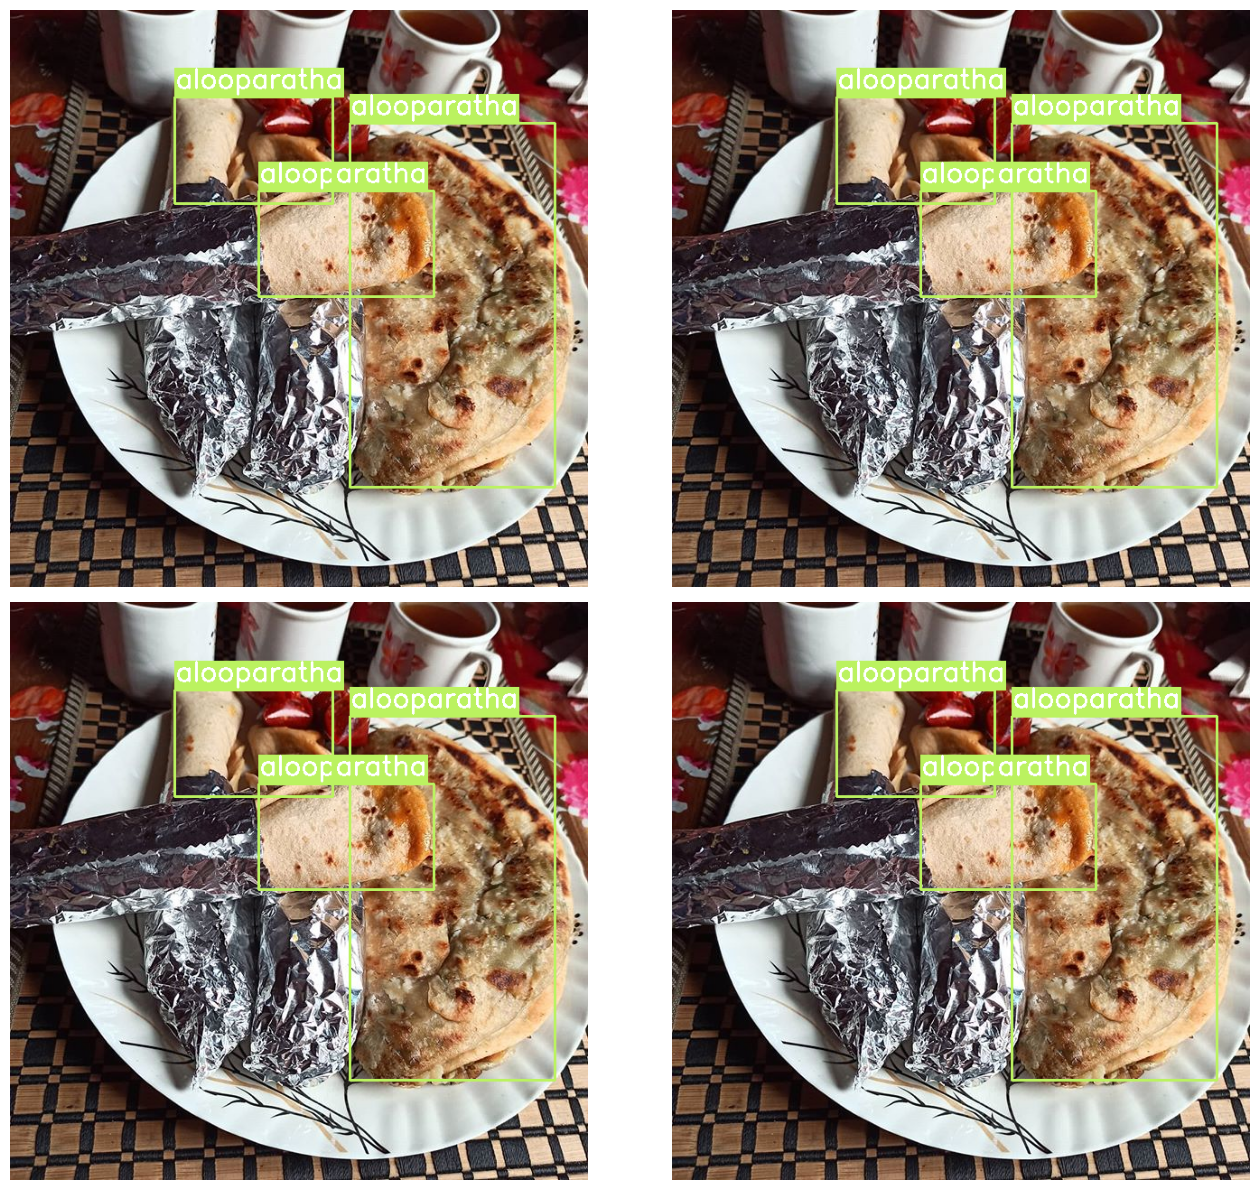

In [ ]:
# Visualize a few training images.
plot(
    image_paths='/content/images/train/alooparatha_1000.jpg',
    label_paths='/content/labels/train/alooparatha_1000.txt',
    num_samples=4,
)

In [ ]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

In [ ]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

In [ ]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 16027, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 16027 (delta 3), reused 10 (delta 1), pack-reused 16008
Receiving objects: 100% (16027/16027), 14.61 MiB | 29.28 MiB/s, done.
Resolving deltas: 100% (11014/11014), done.


In [ ]:
%cd yolov5/
!pwd

/content/yolov5
/content/yolov5


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.5/612.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
monitor_tensorboard()

In [ ]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data /content/data.yaml --weights yolov5x.pt \
    --img 256 --epochs 100 --batch-size 16 --name {RES_DIR}

Current number of result directories: 0
results_1
train: weights=yolov5x.pt, cfg=, data=/content/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=256, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_1, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-187-g0004c74 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2,

In [ ]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data /content/data.yaml --weights yolov5x.pt \
    --img 128 --epochs 100 --batch-size 64 --name {RES_DIR}

Current number of result directories: 1
results_2
train: weights=yolov5x.pt, cfg=, data=/content/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=64, imgsz=128, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_2, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-190-gb1a1808 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2,

In [ ]:
!cp -r "/content/yolov5/runs" "/content/drive/MyDrive"

In [ ]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data /content/changed_dataset/data.yaml --weights /content/yolov5/runs/train/results_2/weights/best.pt \
    --img 640 --epochs 1 --batch-size 16 --name {RES_DIR}

Current number of result directories: 3
results_4
train: weights=/content/yolov5/runs/train/results_2/weights/best.pt, cfg=, data=/content/changed_dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_4, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-181-g3812a1a Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.

In [ ]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [ ]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

In [ ]:
!python detect.py --source /content/changed_dataset/images/test --weights /content/yolov5/runs/train/results_2/weights/best.pt --conf 0.25 --name yolo_road_det

detect: weights=['/content/yolov5/runs/train/results_2/weights/best.pt'], source=/content/changed_dataset/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_road_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-181-g3812a1a Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 322 layers, 86233975 parameters, 0 gradients, 203.9 GFLOPs
image 1/2821 /content/changed_dataset/images/test/alooparatha_0.jpg: 640x640 1 alooparatha, 59.5ms
image 2/2821 /content/changed_dataset/images/test/alooparatha_1.jpg: 640x640 1 alooparatha, 59.4ms
image 3/2821 /content/changed_dataset/images/test/alooparatha_10.jpg: 640x640 1 alooparatha, 56.3

In [ ]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"/content/drive/MyDrive/for testing on random images/images.jpeg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [ ]:
!cp -r "/content/yolov5/runs" "/content/drive/MyDrive"

confusion_matrix.png				     results.csv
events.out.tfevents.1688405286.61e1ecbe364e.23147.0  results.png
F1_curve.png					     train_batch0.jpg
hyp.yaml					     train_batch1.jpg
labels_correlogram.jpg				     train_batch2.jpg
labels.jpg					     val_batch0_labels.jpg
opt.yaml					     val_batch0_pred.jpg
P_curve.png					     val_batch1_labels.jpg
PR_curve.png					     val_batch1_pred.jpg
R_curve.png					     weights
['runs/train/results_2/val_batch1_pred.jpg', 'runs/train/results_2/val_batch0_pred.jpg']


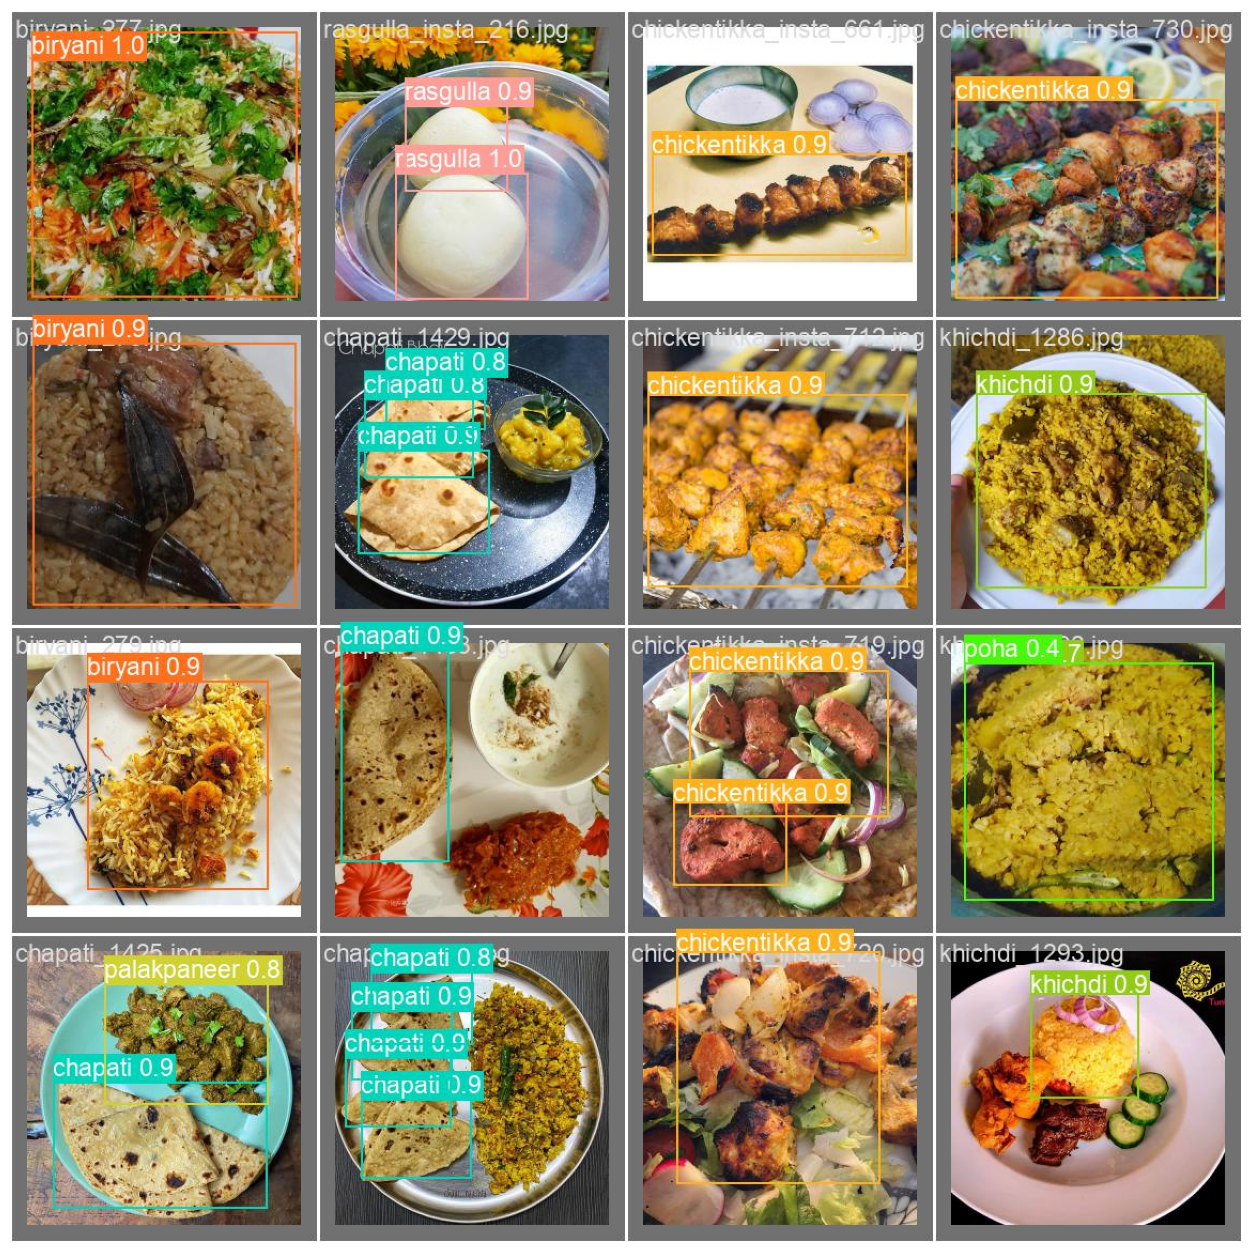

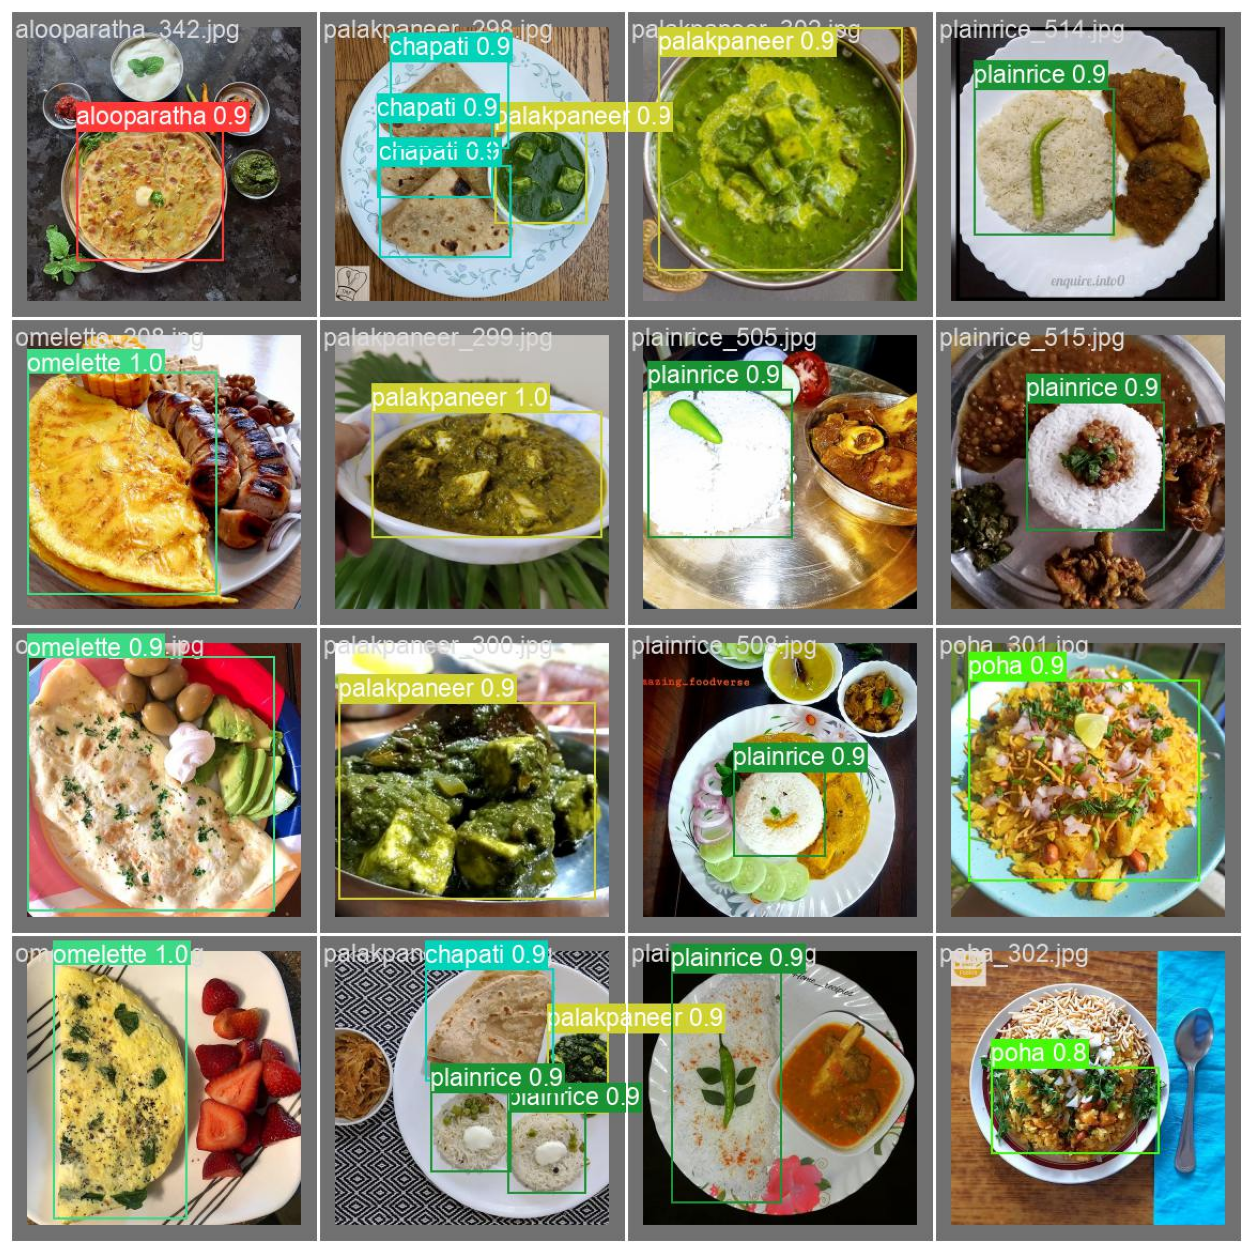

In [ ]:
show_valid_results(RES_DIR)